### Bước 1: 
- Import các công cụ và thư viện

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Import các công cụ từ thư viện scikit-learn để chia dữ liệu, chuẩn hóa và xây dựng mô hình
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Import các mô hình hồi quy
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import xgboost as xgb
# Công cụ để tìm tham số tốt nhất cho mô hình
from sklearn.model_selection import GridSearchCV
# Import các hàm tính toán hiệu suất mô hình
from sklearn.metrics import mean_squared_error, r2_score
# Tắt cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

### Bước 2: 
   - Chọn các đặc trưng quan trọng

In [ ]:
# Tải dữ liệu từ tệp CSV
data = pd.read_csv('air_quality.csv')
# Kiểm tra danh sách các cột trong bộ dữ liệu
print(data.columns)
# Lựa chọn các cột liên quan đến phân tích
selected_data = data[['aqi', 'pollutant', 'so2', 'co', 'o3', 'o3_8hr', 'pm10', 
                      'pm2.5', 'no2', 'nox', 'no', 'windspeed', 'winddirec', 
                      'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg']]

### Bước 3: EDA 
- Chúng ta kiểm tra thông tin dữ liệu và xác định các giá trị thiếu để có thể xử lý sau. 
- Dùng pairplot và heatmap để khảo sát sự tương quan giữa các đặc trưng và tìm hiểu mối quan hệ giữa chúng.

In [ ]:
missing_info = selected_data.isnull().sum()
missing_info = missing_info[missing_info > 0]  # Chỉ hiển thị các cột có giá trị bị thiếu
print(missing_info)
# Chuyển đổi các cột dữ liệu (ngoại trừ 'pollutant') sang dạng số, xử lý lỗi nếu có
numeric_columns = selected_data.columns.difference(['pollutant'])
selected_data[numeric_columns] = selected_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

aqi            43020
pollutant    3235012
so2           139791
co            154131
o3            207426
o3_8hr        153648
pm10          146653
pm2.5         202225
no2           166000
nox           169147
no            169478
windspeed     302683
winddirec     302921
co_8hr        103553
pm2.5_avg      79964
pm10_avg       96170
so2_avg       629185
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882208 entries, 0 to 5882207
Data columns (total 17 columns):
 #   Column     Dtype  
---  ------     -----  
 0   aqi        float64
 1   pollutant  object 
 2   so2        float64
 3   co         float64
 4   o3         float64
 5   o3_8hr     float64
 6   pm10       float64
 7   pm2.5      float64
 8   no2        float64
 9   nox        float64
 10  no         float64
 11  windspeed  float64
 12  winddirec  float64
 13  co_8hr     float64
 14  pm2.5_avg  float64
 15  pm10_avg   float64
 16  so2_avg    float64
dtypes: float64(16), object(1)
memory usage: 762.9+ MB
None


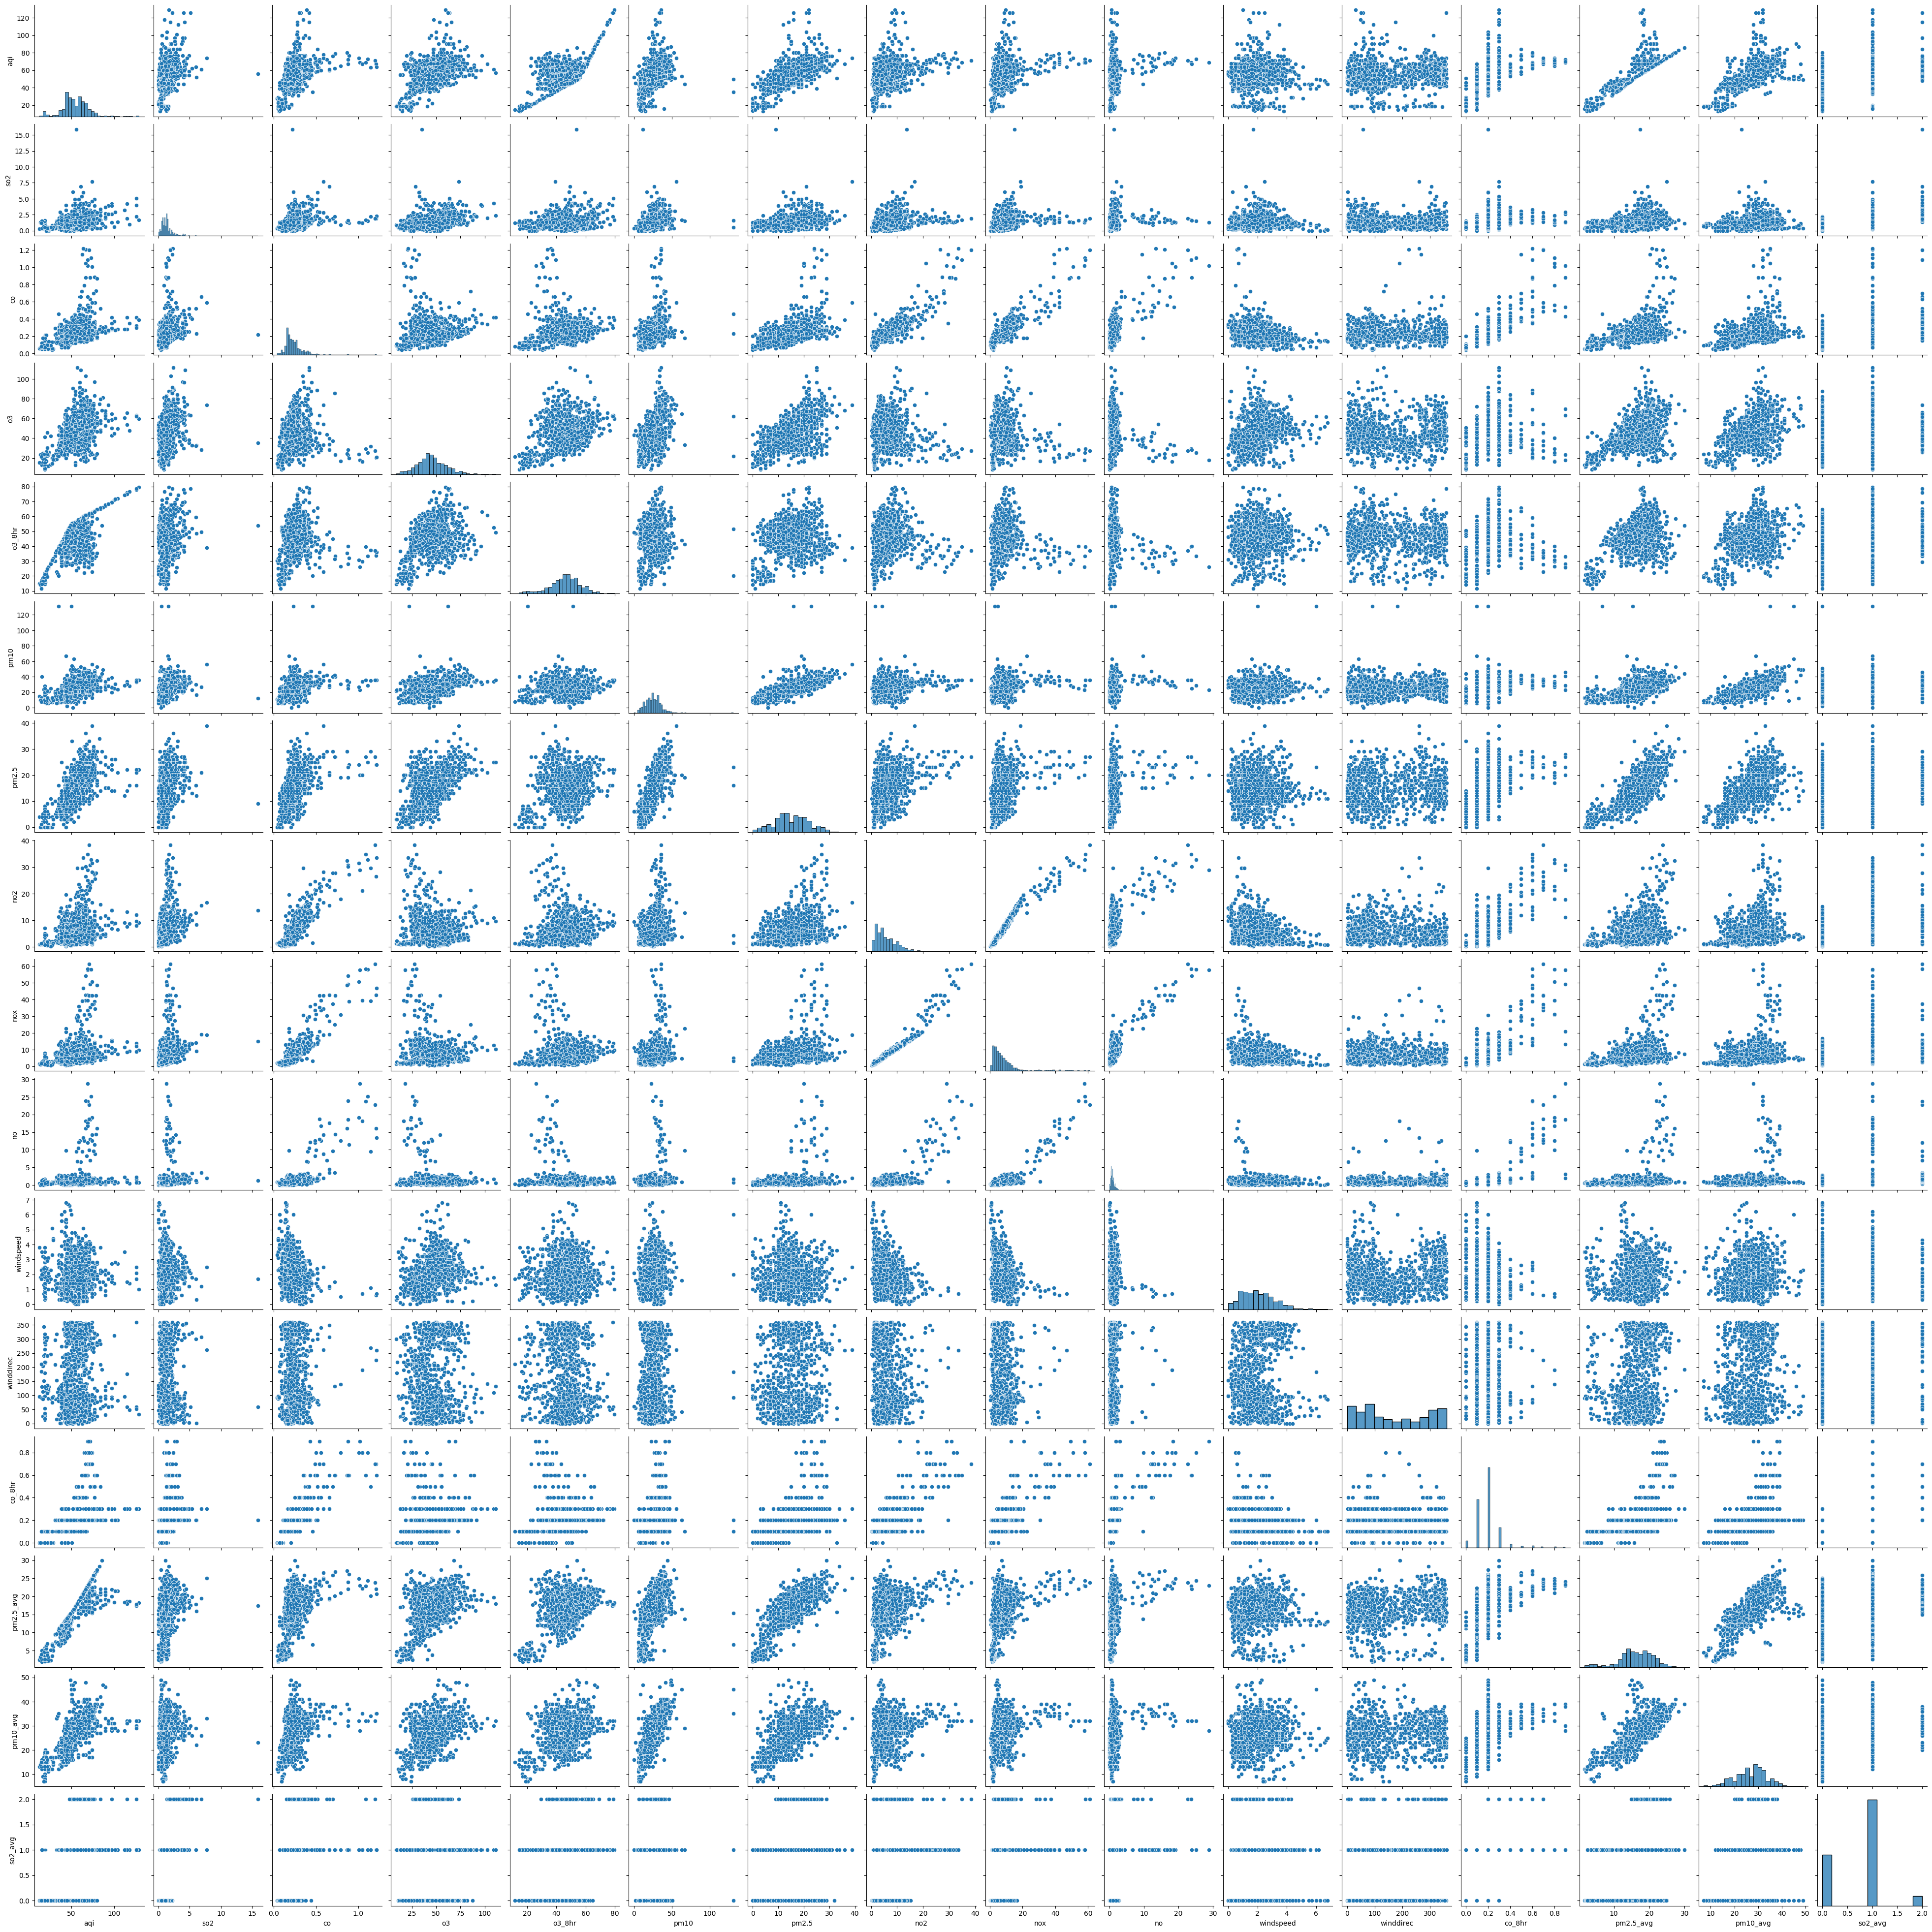

In [16]:
# Vẽ biểu đồ pairplot để kiểm tra mối quan hệ giữa các biến số
numeric_features = selected_data.head(1000).select_dtypes(include=['float64', 'int64']).columns
sns.pairplot(selected_data.head(1000)[numeric_features])
plt.show()

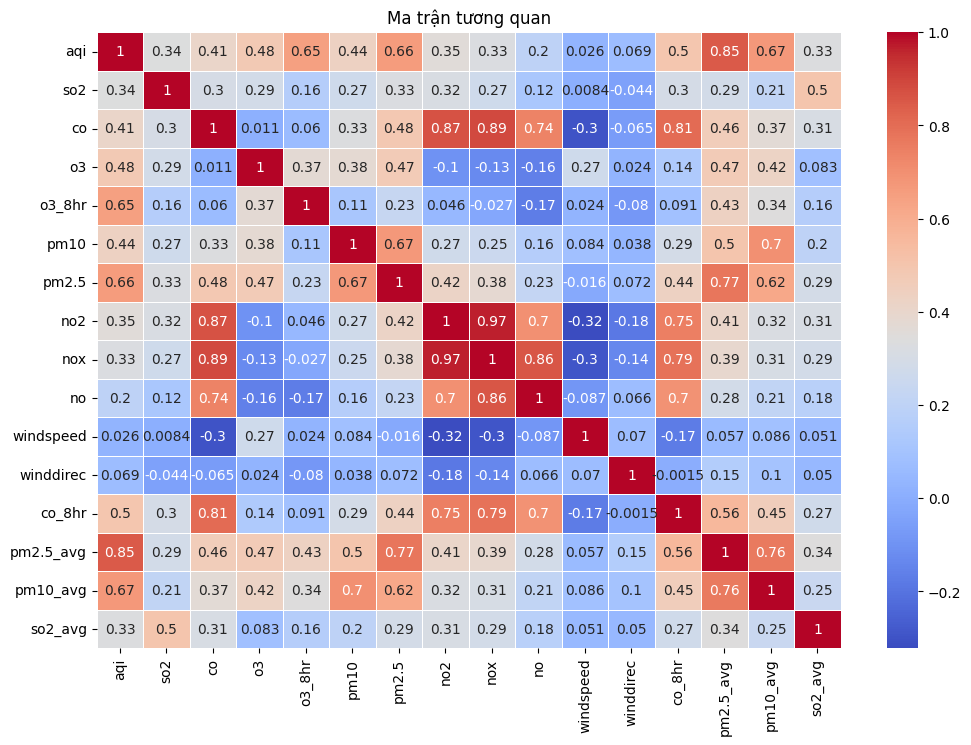

In [17]:
# Tính toán ma trận tương quan giữa các biến số và hiển thị qua heatmap
correlation_matrix = selected_data.head(1000)[numeric_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan')
plt.show()

### Bước 4: Tiền xử lý dữ liệu 
- Xử lý dữ liệu thiếu: Chúng ta loại bỏ các dòng có giá trị thiếu trong các cột quan trọng và thay thế giá trị thiếu của cột 'pollutant' bằng 'nan'.
- Chuyển đổi các cột chứa dữ liệu chuỗi sang dạng số cho các mô hình học máy.

In [18]:
# Xóa các dòng dữ liệu bị thiếu ở các cột quan trọng
selected_data_cleaned = selected_data.dropna(subset=[
    'aqi', 'so2', 'co', 'o3', 'o3_8hr', 'pm10', 'pm2.5', 'no2', 
    'nox', 'no', 'windspeed', 'winddirec', 'co_8hr', 'pm2.5_avg', 
    'pm10_avg', 'so2_avg'
])
# Điền giá trị 'nan' cho cột 'pollutant' nếu bị thiếu
selected_data_cleaned['pollutant'] = selected_data_cleaned['pollutant'].fillna('nan')

### Bước 5: 
- Chuẩn bị dữ liệu cho mô hình
- tách dữ liệu thành hai phần: X (các đặc trưng) và y (chỉ số AQI). Đồng thời sử dụng phương pháp get_dummies để mã hóa các giá trị trong cột 'pollutant'.
- Dữ liệu được chia thành các tập huấn luyện, kiểm tra và validation. Sau đó, chúng ta chuẩn hóa dữ liệu bằng StandardScaler.


In [19]:
# Chuyển đổi cột 'pollutant' sang biến giả (one-hot encoding)
X = selected_data_cleaned.drop('aqi', axis=1)
X = pd.get_dummies(X, columns=['pollutant'], drop_first=True).head(10000)
# Đặt biến mục tiêu là 'aqi'
y = selected_data_cleaned['aqi'].head(10000)

### Bước 6: Huấn luyện và đánh giá mô hình học máy
- Chúng ta áp dụng các mô hình học máy khác nhau như Hồi quy tuyến tính, KNN, SVM, Cây quyết định, AdaBoost, Gradient Boosting, XGBoost để dự báo chỉ số AQI.
- Sau khi huấn luyện, chúng ta tính toán lỗi trung bình bình phương (MSE) để đánh giá chất lượng của mô hình. 

In [20]:
# Chia dữ liệu thành tập huấn luyện, kiểm định và thử nghiệm
X_temp_train, X_test, y_temp_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp_train, y_temp_train, test_size=0.4, random_state=42)
# Chuẩn hóa dữ liệu về thang đo chuẩn
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
# Hiển thị kích thước dữ liệu sau khi chia
print(f"X_train: {X_train_scaled.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val_scaled.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test_scaled.shape}, y_test: {y_test.shape}")

X_train: (3600, 22), y_train: (3600,)
X_val: (2400, 22), y_val: (2400,)
X_test: (4000, 22), y_test: (4000,)


### Bước 7: So sánh hiệu suất mô hình
- Mỗi mô hình sẽ có MSE khác nhau, và chúng ta so sánh các mô hình để chọn ra mô hình có hiệu suất tốt nhất.

In [7]:
# Tạo danh sách các mô hình cần thử nghiệm
models = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(),
    "SVM": SVR(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42)
}
# Dictionary để lưu kết quả
results = {}
# Huấn luyện và đánh giá từng mô hình
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_val_scaled)
    mse = mean_squared_error(y_val, predictions)
    results[model_name] = mse
    print(f"{model_name} MSE: {mse:.4f}")
# Tạo bảng so sánh hiệu suất các mô hình
performance_df = pd.DataFrame(list(results.items()), columns=['Model', 'MSE']).sort_values(by='MSE')
print(performance_df)

Linear Regression MSE: 20.7174
KNN MSE: 21.1523
SVM MSE: 24.3248
Decision Tree MSE: 0.8854
AdaBoost MSE: 12.4084
Gradient Boosting MSE: 0.8721
XGBoost MSE: 1.2023
               Model        MSE
5  Gradient Boosting   0.872119
3      Decision Tree   0.885417
6            XGBoost   1.202290
4           AdaBoost  12.408416
0  Linear Regression  20.717361
1                KNN  21.152350
2                SVM  24.324761


### Bước 8: Dự đoán biểu đồ & vẽ kết quả: 
- Chúng ta vẽ biểu đồ Thực tế vs Dự đoán để kiểm tra độ chính xác của các mô hình.

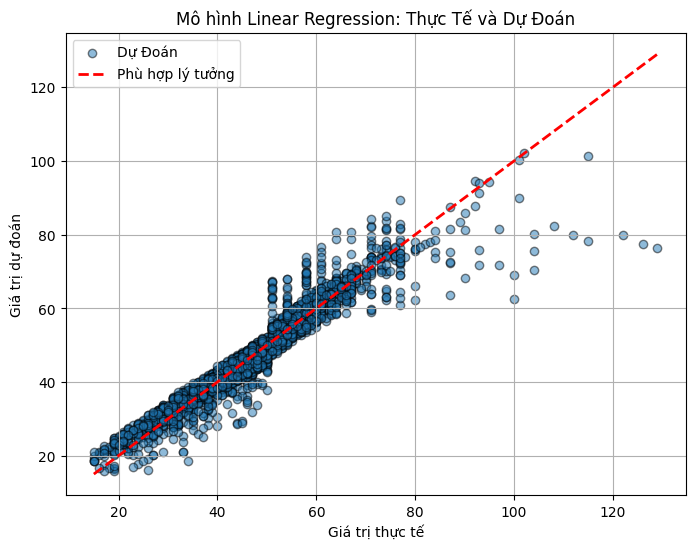

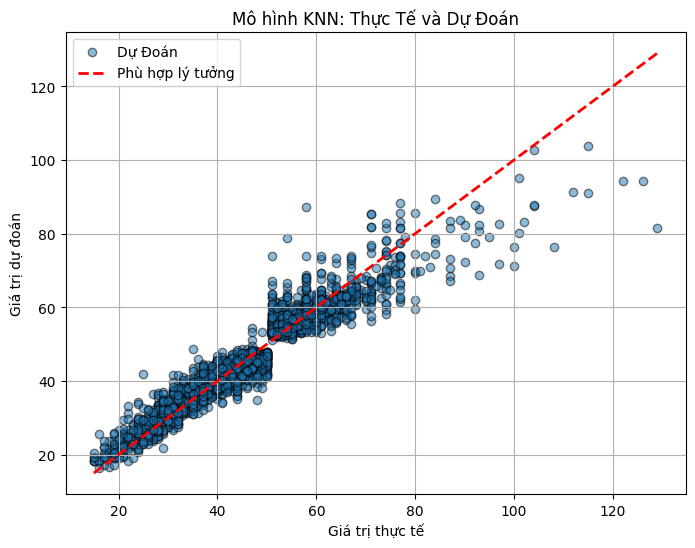

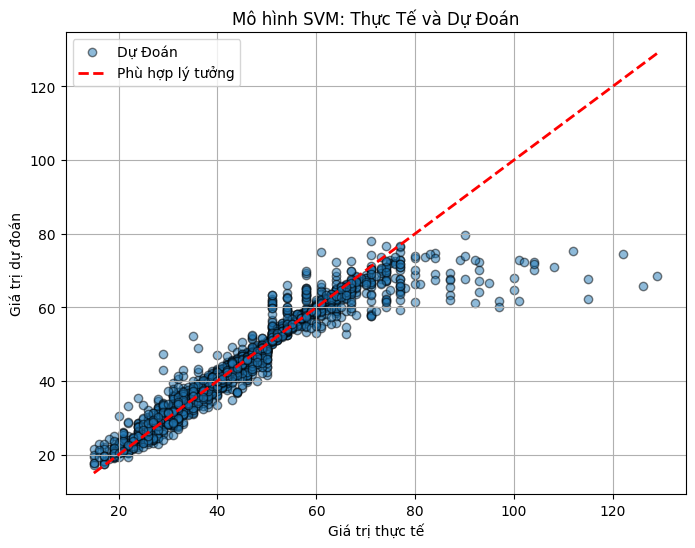

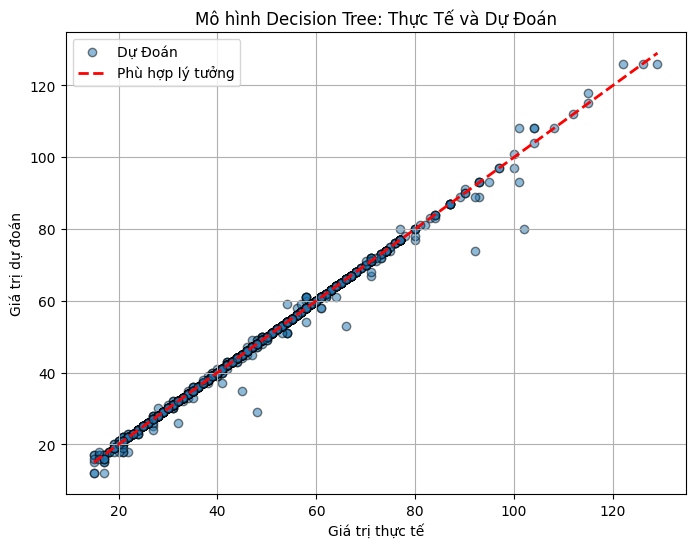

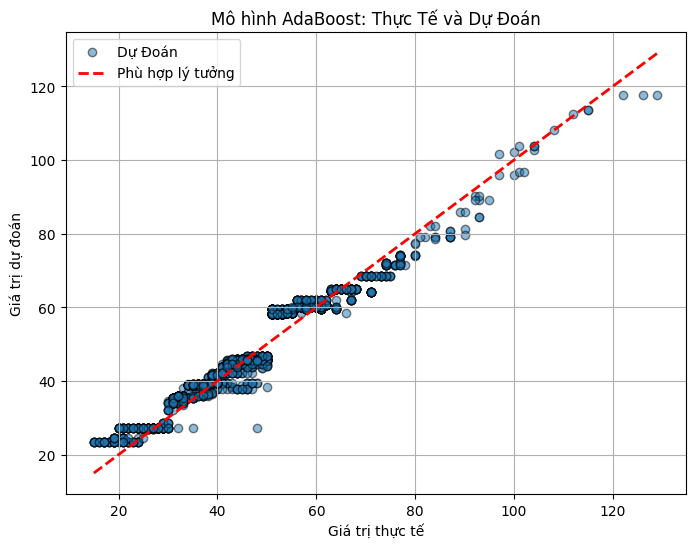

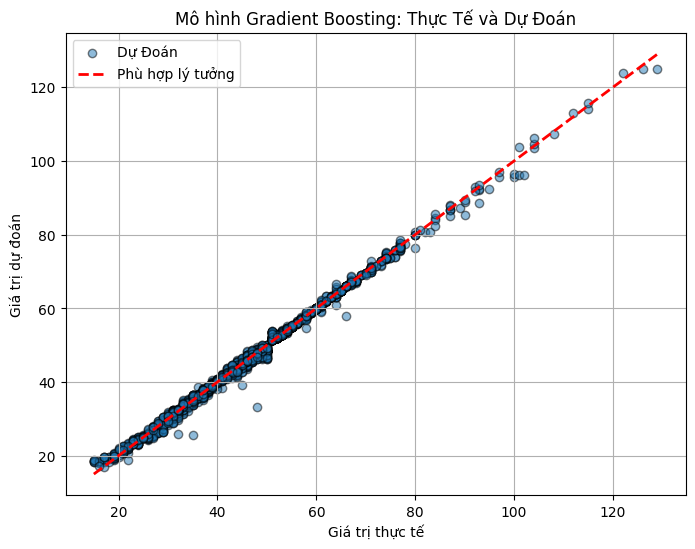

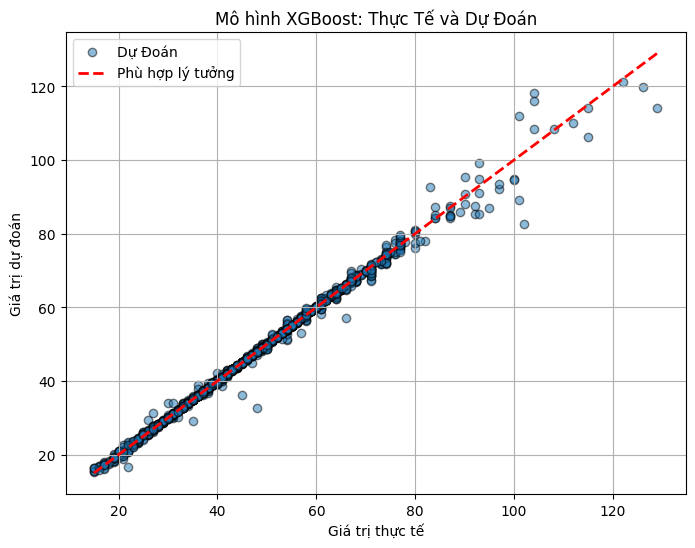

In [9]:
# Hàm để vẽ biểu đồ giá trị thực tế và giá trị dự đoán
def plot_predictions(actual, predicted, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(actual, predicted, alpha=0.5, edgecolor='k', label='Dự Đoán')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', lw=2, linestyle='--', label='Phù hợp lý tưởng')
    plt.title(f'Mô hình {model_name}: Thực Tế và Dự Đoán')
    plt.xlabel('Giá trị thực tế')
    plt.ylabel('Giá trị dự đoán')
    plt.legend()
    plt.grid()
    plt.show()
# Vẽ biểu đồ cho từng mô hình
for model_name, model in models.items():
    predictions = model.predict(X_val_scaled)
    plot_predictions(y_val, predictions, model_name)